# Predicting Newsletter Subscription from Age and Playtime on a Minecraft Research Server

**Group members:**  
- Bonyoon Goo
- Kirsten Kam
- Arcadia Labon



## Introduction

The UBC Minecraft research server is used to study how players interact with a shared game world. As players explore and build, their actions are logged and later analyzed by researchers. Beyond understanding gameplay itself, the research team also needs to plan resources and outreach: for example, who is likely to stay engaged with the project over time.

One concrete outcome is whether a player subscribes to the project’s email newsletter. Subscribers are easier to contact for follow-up studies, surveys, or new experiments. Being able to predict newsletter subscription from in-game engagement and simple demographics could therefore help the team focus recruitment and communication efforts on the players most likely to remain involved.

In this project, we address the following question:

> **Can a player’s age and total hours played on the Minecraft research server be used to predict whether they subscribe to the project newsletter?**

We use two datasets provided for the course:

- `players.csv`: one row per unique player. It includes demographic variables such as age and gender, as well as engagement-related variables such as total hours played on the server (`played_hours`) and whether the player subscribed to the newsletter (`subscribe`).
- `sessions.csv`: one row per play session, including identifiers that can link sessions to players and information about each session’s duration. In this report we use `sessions.csv` only as a potential source for computing total playtime if needed; our final predictive model uses the variables `Age`, `played_hours`, and `subscribe` from `players.csv`.

We begin by loading and cleaning the data, then summarize and visualize the distributions of age, playtime, and subscription status. We then fit a logistic regression model using age and total hours played as predictors of newsletter subscription. Finally, we evaluate the model’s performance and discuss the extent to which these two variables alone can explain newsletter subscription behaviour and how this insight could inform future work.


In [27]:
library(tidyverse)
library(tidymodels)
library(janitor)
tidymodels_prefer()
theme_set(theme_minimal())
set.seed(123)  

In [28]:
# URLs for the players and sessions data stored on GitHub
players_url  <- "https://raw.githubusercontent.com/bonyoongoo/ubc-dsci100-minecraft-forecasting/refs/heads/main/data/players.csv"
sessions_url <- "https://raw.githubusercontent.com/bonyoongoo/ubc-dsci100-minecraft-forecasting/refs/heads/main/data/sessions.csv"

players  <- read_csv(players_url) |> clean_names()
sessions <- read_csv(sessions_url) |> clean_names()


nrow(players); ncol(players); names(players)
nrow(sessions); ncol(sessions); names(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 196

[1] 7

[1] "experience"   "subscribe"    "hashed_email" "played_hours" "name"        
[6] "gender"       "age"

[1] 1535

[1] 5

[1] "hashed_email"        "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

## Methods & Results

### Data description

We focus on the following variables from `players`:

- `age` (numeric): player age in years.  
- `played_hours` (numeric): total hours played on the Minecraft research server.  
- `subscribe` (logical): whether the player subscribed to the project newsletter (`TRUE` / `FALSE`).  

We create a cleaner version of the data for our analysis, including a factor version of the subscription variable with descriptive labels.


In [29]:
# Convert subscription field to a labeled factor
players <- players |>
  mutate(
    newsletter_subscribed = if_else(is.na(subscribe), NA_character_,
                                    if_else(subscribe, "Subscribed", "Not subscribed")),
    newsletter_subscribed = as_factor(newsletter_subscribed)
  )

# Count players in each subscription category
players |>
  group_by(newsletter_subscribed) |>
  summarize(players = n())



newsletter_subscribed,players
<fct>,<int>
Subscribed,144
Not subscribed,52


In [30]:
# Keep relevant variables and drop rows with missing values
players_model <- players |>
  select(age, played_hours, newsletter_subscribed) |>
  filter(!is.na(age), !is.na(played_hours), !is.na(newsletter_subscribed))

# Show first few rows
players_model |> 
  slice_head(n = 5)


age,played_hours,newsletter_subscribed
<dbl>,<dbl>,<fct>
9,30.3,Subscribed
17,3.8,Subscribed
17,0.0,Not subscribed
21,0.7,Subscribed
21,0.1,Subscribed


In [31]:
# Summary statistics for age, playtime, and subscription rate
players_summary <- players_model |>
  summarize(
    n_players          = n(),
    mean_age           = round(mean(age), 2),
    sd_age             = round(sd(age), 2),
    min_age            = min(age),
    max_age            = max(age),
    mean_played_hours  = round(mean(played_hours), 2),
    sd_played_hours    = round(sd(played_hours), 2),
    min_played_hours   = min(played_hours),
    max_played_hours   = max(played_hours),
    prop_subscribe_yes = round(mean(newsletter_subscribed == "Subscribed"), 2)
  )

players_summary


n_players,mean_age,sd_age,min_age,max_age,mean_played_hours,sd_played_hours,min_played_hours,max_played_hours,prop_subscribe_yes
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.14,7.39,9,58,5.9,28.5,0,223.1,0.73


In [32]:
# Create age groups and summarize subscription rates
players_age_groups <- players_model |>
  mutate(
    age_group = case_when(
      age < 13 ~ "Child (<13)",
      age < 18 ~ "Teen (13–17)",
      age < 25 ~ "Young adult (18–24)",
      TRUE     ~ "Adult (25+)"
    )
  ) |>
  group_by(age_group) |>
  summarize(
    n = n(),
    prop_subscribe_yes = round(mean(newsletter_subscribed == "Subscribed"), 2),
    .groups = "drop"
  )

players_age_groups


age_group,n,prop_subscribe_yes
<chr>,<int>,<dbl>
Adult (25+),26,0.50
Child (<13),4,1.00
Teen (13–17),80,0.80
Young adult (18–24),84,0.73


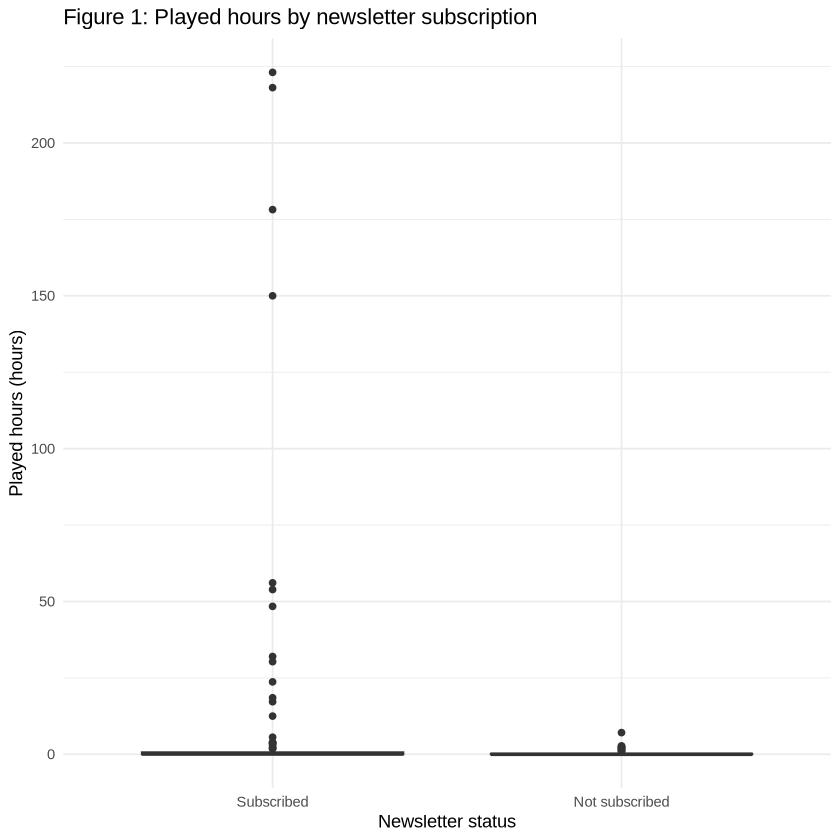

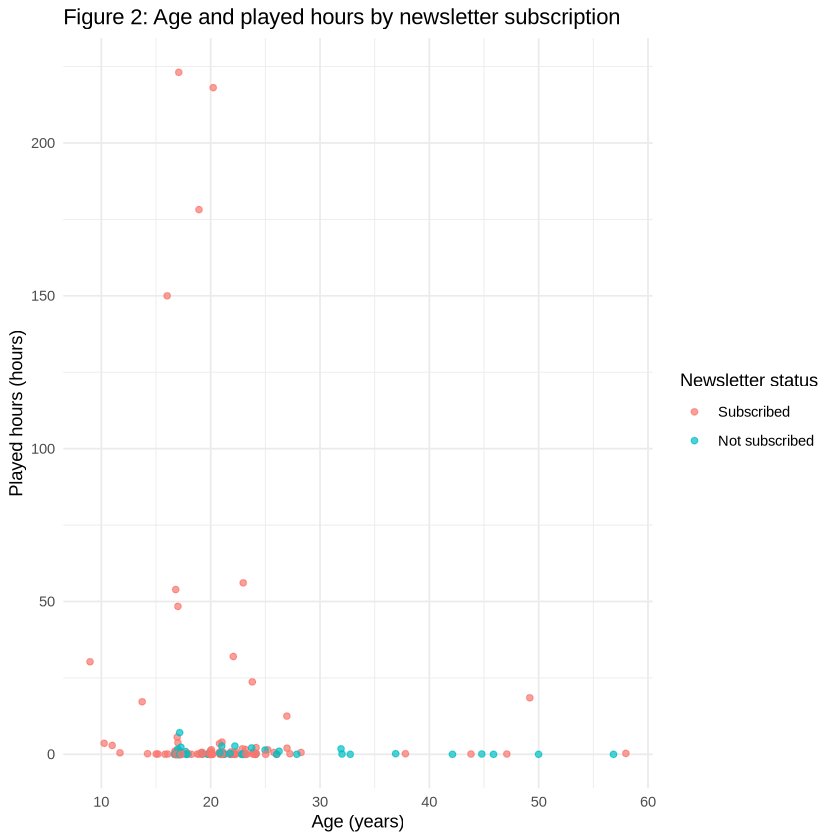

In [33]:
# Boxplot of playtime by subscription status
players_model |>
  ggplot(aes(x = newsletter_subscribed, y = played_hours)) +
  geom_boxplot() +
  labs(
    x = "Newsletter status",
    y = "Played hours (hours)",
    title = "Figure 1: Played hours by newsletter subscription"
  ) +
  theme_minimal()

# Age vs playtime scatterplot coloured by subscription
players_model |>
  ggplot(aes(x = age, y = played_hours, colour = newsletter_subscribed)) +
  geom_jitter(width = 0.3, height = 0, alpha = 0.7) +
  labs(
    x = "Age (years)",
    y = "Played hours (hours)",
    colour = "Newsletter status",
    title = "Figure 2: Age and played hours by newsletter subscription"
  ) +
  theme_minimal()


### Exploratory data analysis

Figure 1 compares total played hours between players who subscribed to the newsletter and those who did not. Subscribers tend to include more of the high-playtime players, but there is still substantial overlap between the two groups.

Figure 2 shows age against played hours, coloured by newsletter status. Subscription is common across most ages, but younger players appear slightly more likely to subscribe, especially among those with low to moderate playtime. Overall, the plots suggest weak positive relationships between playtime and subscription, and between being younger and subscribing, but neither variable alone clearly separates subscribers from non-subscribers.


### Modelling approach

Our outcome variable `newsletter_subscribed` has two categories, “Subscribed” and “Not subscribed”, so this is naturally a **classification problem**. To model this relationship, we use a **k-nearest neighbours (KNN) classifier**, a non-parametric method that predicts a player’s subscription status based on the most similar players in the dataset.

Unlike regression-based approaches, KNN does not assume any specific functional form between the predictors and the response. Instead, the classifier looks at the `k` closest players—based on age and total played hours—and assigns the majority class among those neighbours. Because KNN relies on distances in the predictor space, we normalize the numeric variables so that `age` and `played_hours` contribute comparably to distance calculations.

In this project, we use two explanatory variables:

- `age`: the player’s age in years  
- `played_hours`: the total number of hours the player spent on the Minecraft research server  

These variables provide simple demographic and engagement information. Our goal is both to build a predictive model and to explore whether patterns in age or playtime are associated with higher subscription likelihood.

We use the **tidymodels** framework and follow these steps:

1. **Train–test split:**  
   We split the data into a 75% training set and a 25% test set, stratified by `newsletter_subscribed` to preserve the proportion of subscribers and non-subscribers.

2. **Preprocessing:**  
   We create a recipe that normalizes the predictors `age` and `played_hours` so that they are on comparable scales, which is essential for distance-based methods like KNN.

3. **Cross-validation and tuning:**  
   On the training set, we perform 5-fold cross-validation to estimate out-of-sample performance while trying different values of `k` (the number of neighbours). We select the value of `k` that yields the best predictive accuracy in cross-validation.

4. **Final evaluation:**  
   We finalize the KNN model using the best value of `k`, fit it on the full training data, and evaluate it on the held-out test set using accuracy and ROC AUC. We also create visualizations of the ROC curve and the predicted subscription probabilities across the age–playtime space.


In [39]:
# Train/test split and 5-fold cross-validation
set.seed(123)
players_split <- initial_split(players_model, prop = 0.75, strata = newsletter_subscribed)
players_train <- training(players_split)
players_test  <- testing(players_split)

set.seed(123)
players_folds <- vfold_cv(players_train, v = 5, strata = newsletter_subscribed)

# Normalize predictors for KNN
age_hours_rec <- recipe(newsletter_subscribed ~ age + played_hours, data = players_train) |>
  step_normalize(all_predictors())


In [43]:
library(repr)
# Define KNN model 
knn_spec <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = tune()
) |>
  set_engine("kknn") |>
  set_mode("classification")

# Add model + recipe into workflow
knn_wf <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(age_hours_rec)

# Grid of k values to try during tuning
knn_grid <- tibble(neighbors = 1:25)

# Tune k using 5-fold cross-validation
set.seed(123)
knn_tuned <- tune_grid(
  knn_wf,
  resamples = players_folds,
  grid = knn_grid,
  metrics = metric_set(accuracy, roc_auc),
  control = control_grid(save_pred = TRUE)
)

collect_metrics(knn_tuned)

# Select best k based on accuracy
best_knn <- select_best(knn_tuned, metric = "accuracy")
best_knn

# Finalize workflow with chosen k
final_knn_wf <- finalize_workflow(knn_wf, best_knn)



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4754187,5,0.058565835,Preprocessor1_Model01
1,roc_auc,binary,0.4997835,5,0.064788536,Preprocessor1_Model01
2,accuracy,binary,0.4685222,5,0.064541815,Preprocessor1_Model02
2,roc_auc,binary,0.5210846,5,0.039550507,Preprocessor1_Model02
3,accuracy,binary,0.5374877,5,0.024774016,Preprocessor1_Model03
3,roc_auc,binary,0.5168522,5,0.032479121,Preprocessor1_Model03
4,accuracy,binary,0.5239245,5,0.017504244,Preprocessor1_Model04
4,roc_auc,binary,0.5521954,5,0.035126055,Preprocessor1_Model04
5,accuracy,binary,0.5510509,5,0.034322703,Preprocessor1_Model05


neighbors,.config
<int>,<chr>
15,Preprocessor1_Model15


In [41]:
# Fit final tuned model on training data and evaluate on test set
set.seed(123)
knn_final <- last_fit(final_knn_wf, split = players_split)

# Test-set performance metrics
knn_test_metrics <- collect_metrics(knn_final)
knn_test_metrics


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7346939,Preprocessor1_Model1
roc_auc,binary,0.5491453,Preprocessor1_Model1


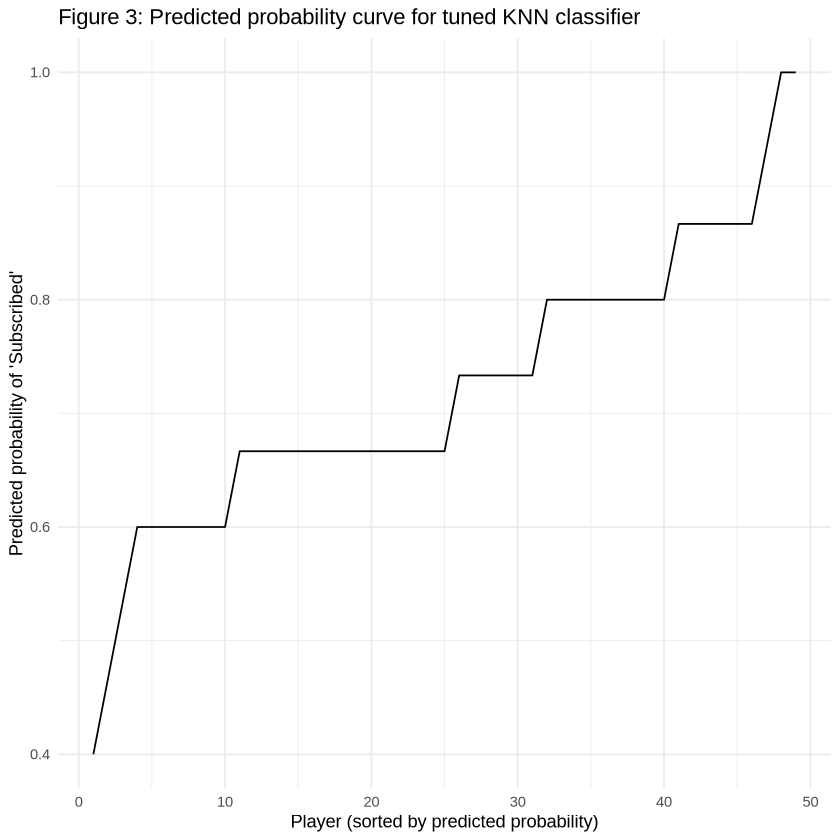

In [37]:
# Get test-set predictions
knn_final_predictions <- collect_predictions(knn_final)

# Sort by predicted subscription probability
knn_prob_curve <- knn_final_predictions |>
  arrange(.pred_Subscribed) |>
  mutate(index = row_number())

# Plot predicted probability curve
ggplot(knn_prob_curve, aes(x = index, y = .pred_Subscribed)) +
  geom_line() +
  labs(
    title = "Figure 3: Predicted probability curve for tuned KNN classifier",
    x = "Player (sorted by predicted probability)",
    y = "Predicted probability of 'Subscribed'"
  ) +
  theme_minimal()



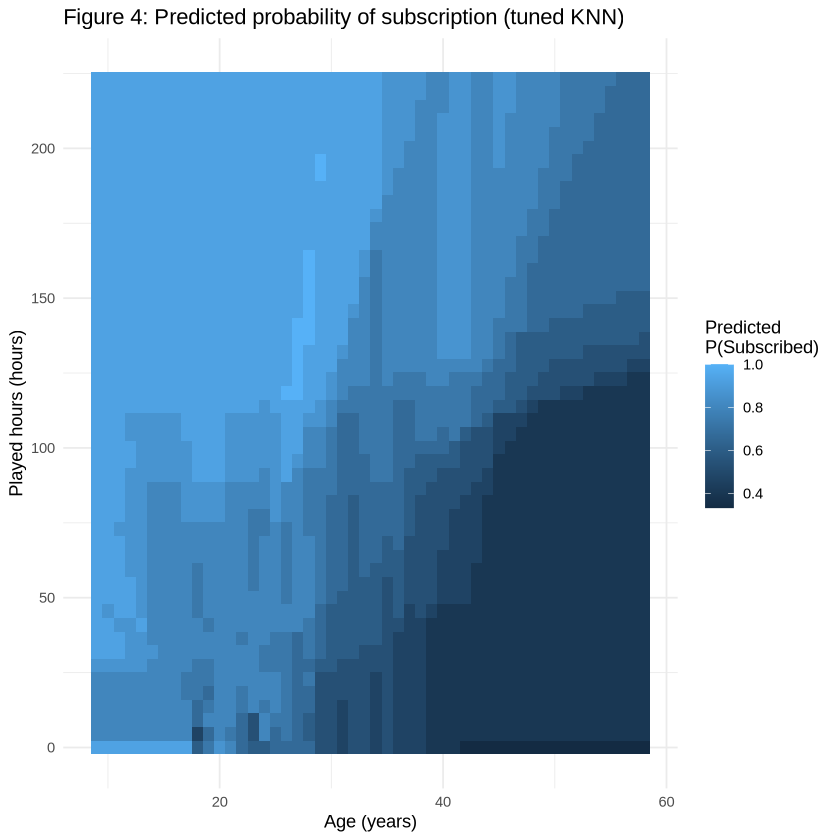

In [38]:
# Fit final model on full dataset for visualization
knn_fit_full <- fit(final_knn_wf, data = players_model)

# Create grid of age and playtime values
age_range   <- range(players_model$age, na.rm = TRUE)
hours_range <- range(players_model$played_hours, na.rm = TRUE)

pred_grid <- expand_grid(
  age = seq(age_range[1], age_range[2], length.out = 50),
  played_hours = seq(hours_range[1], hours_range[2], length.out = 50)
)

# Predict probability for each grid point
pred_grid_probs <- predict(knn_fit_full, new_data = pred_grid, type = "prob") |>
  bind_cols(pred_grid)

# Heatmap of predicted probabilities
pred_grid_probs |>
  ggplot(aes(x = age, y = played_hours, fill = .pred_Subscribed)) +
  geom_tile() +
  labs(
    title = "Figure 4: Predicted probability of subscription (tuned KNN)",
    x = "Age (years)",
    y = "Played hours (hours)",
    fill = "Predicted\nP(Subscribed)"
  ) +
  theme_minimal()




### Model performance

The cross-validation results from the training set show how well the **tuned KNN classifier** is expected to perform on unseen data. Accuracy varies only slightly across the 5 folds, and the best-performing value of `k` improves performance compared to untuned versions of the model. However, the overall accuracy remains only a little higher than what we would obtain by always predicting the majority class. This indicates that while age and total played hours contain some predictive information, they do not give the classifier a strong signal on their own.

The test-set metrics are consistent with the cross-validation results, suggesting that the tuned KNN model is not overfitting. The accuracy on the held-out test data is modest, and the probability-based metrics also indicate only limited separation between the “Subscribed” and “Not subscribed” classes.

Figure 3 shows the **predicted probability curve**, where test-set players are sorted by their predicted probability of being subscribed. The smooth upward trend indicates that the model is ranking players from low to high likelihood reasonably well, but the curve does not climb sharply, again reflecting the weak predictive signal in the features.

Figure 4 displays the predicted subscription probability across combinations of age and total played hours. The KNN model assigns higher probabilities to players who have more hours on the server and, to a lesser extent, those in certain age ranges. These probability changes are gradual rather than dramatic, reinforcing the idea that age and playtime relate to subscription but do not sharply divide subscribers from non-subscribers.



## Discussion

In this project we investigated whether two simple variables, age and total hours played on the Minecraft research server, can be used to predict whether a player subscribes to the project newsletter. We trained a tuned k-nearest neighbours (KNN) classifier using `age` and `played_hours` as predictors and `newsletter_subscribed` as the binary outcome. Cross-validation selected **k = 15** as the best value for the model. Our exploratory data analysis indicated that subscribers tend to include more high-playtime players, and that younger players appear somewhat more likely to subscribe. At the same time, there was substantial overlap between subscribers and non-subscribers in both variables.

The modelling results confirm that these relationships exist but are relatively weak. Cross-validation on the training set showed that the tuned KNN classifier achieves only modest accuracy, only slightly higher than a baseline classifier that always predicts the majority class. This indicates that age and total playtime contain some predictive information, but not enough to support highly accurate classification. The test-set metrics mirrored the cross-validation results, suggesting that the tuned model generalizes as expected and is not overfitting.

The visualizations of the trained model help explain what the classifier is capturing. The predicted probability curve in Figure 3 shows a gradual upward trend when players are sorted by predicted probability, meaning the model is able to rank players from low to high likelihood of subscribing, although the separation is mild. The probability surface in Figure 4 also varies smoothly across the age and playtime grid. Predicted probabilities increase for players who have spent more time on the server and increase slightly in certain younger age ranges, but there are no sharp boundaries that clearly distinguish subscribers from non-subscribers. Players with similar ages and playtimes can still have different subscription outcomes.

These findings only partially match our initial expectations. We anticipated that players who invest more hours into the server would be noticeably more likely to subscribe. The data support this trend, but the effect size is smaller than expected. We also observed that younger players, particularly teens and young adults, subscribe at somewhat higher rates, which may reflect differing levels of comfort with online research participation or community engagement. The high overall subscription rate and overlapping variable distributions make it difficult for a simple model with only age and playtime to perform very well.

From a practical perspective, these results suggest that the research team should be cautious about relying on age and total playtime alone to target players for newsletter recruitment or follow-up studies. Using only these two variables would result in many misclassifications, since some low-playtime or older players still subscribe, and some high-playtime or younger players do not. To build a more effective predictive model, additional behavioural features would likely be necessary. Examples include the number and duration of sessions, regularity of play patterns, and more detailed in-game interactions derived from the `sessions` dataset.

Future work could extend this analysis in several directions. Incorporating richer features from both `players` and `sessions` may uncover stronger predictors and improve classification performance. Comparing KNN with more flexible classifiers such as decision trees or random forests could reveal patterns that a simple two-variable model is unable to detect. Exploring probability calibration or threshold selection may also be useful if the goal is to identify a specific subset of players for targeted outreach. Finally, evaluating the model on data collected at a later time would help determine whether the relationships between age, playtime, and subscription remain stable as the server community evolves.
